TRAIN_DIR: C:\Users\pc\Desktop\i2\deeplearning\projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\pc\Desktop\i2\deeplearning\projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


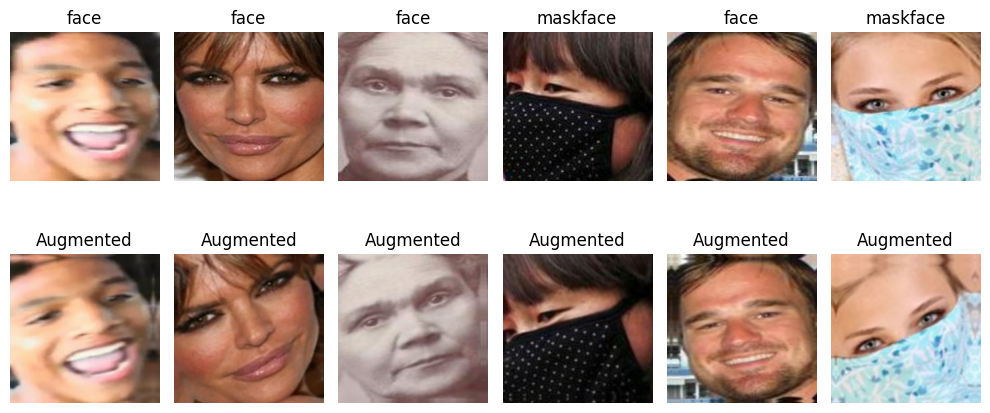

In [2]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

In [3]:
import os
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles :", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPUs disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#  Modèle 1 : CNN simple (baseline)

Dans cette section, on définit un premier modèle CNN simple qui servira de **baseline** :

- Quelques couches convolution + max pooling
- Flatten + fully connected
- Normalisation intégrée dans le modèle (`Rescaling`)
- Data augmentation appliquée uniquement côté entraînement

On l’entraîne ensuite sur `train_ds`, on valide sur `val_ds`, puis on l’évalue sur `test_ds`.


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = IMG_SIZE + (3,)

model1 = keras.Sequential(
    [
        layers.Input(shape=input_shape),

        # Data augmentation (uniquement en mode training)
        data_augmentation,

        # Normalisation [0, 1]
        layers.Rescaling(1./255),

        # Bloc 1
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        # Bloc 2
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        # Bloc 3
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # binaire : mask / no mask
    ],
    name="cnn_baseline"
)


model1.summary()

Model: "cnn_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)      

## Compilation du modèle et callbacks

On utilise :

- `Adam` comme optimiseur,
- `binary_crossentropy` comme fonction de perte,
- des métriques : accuracy, précision, rappel,
- des callbacks :
  - `EarlyStopping` pour arrêter si la val_loss ne s'améliore plus,
  - `ReduceLROnPlateau` pour diminuer le learning rate.


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)
checkpointer = ModelCheckpoint(
    "models/best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

##  Entraînement du modèle 1

On entraîne le modèle sur l'ensemble d'entraînement et on suit les performances sur validation.


In [6]:
EPOCHS = 20

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpointer]
)

Epoch 1/20
149/149 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8373 - precision: 0.8401 - recall: 0.8294
Epoch 1: val_loss improved from inf to 0.28069, saving model to models\best_model.h5
149/149 [==============================] - 75s 392ms/step - loss: 0.4319 - accuracy: 0.8373 - precision: 0.8401 - recall: 0.8294 - val_loss: 0.2807 - val_accuracy: 0.8973 - val_precision: 0.9590 - val_recall: 0.8374 - lr: 0.0010
Epoch 2/20
149/149 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8915 - precision: 0.9064 - recall: 0.8710
Epoch 2: val_loss improved from 0.28069 to 0.21980, saving model to models\best_model.h5
149/149 [==============================] - 48s 319ms/step - loss: 0.2926 - accuracy: 0.8915 - precision: 0.9064 - recall: 0.8710 - val_loss: 0.2198 - val_accuracy: 0.9209 - val_precision: 0.9677 - val_recall: 0.8764 - lr: 0.0010
Epoch 3/20
149/149 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9066 - prec

##  Courbes d'apprentissage (accuracy et loss)

On trace l'évolution de la **loss** et de l'**accuracy** sur train et validation pour analyser le comportement du modèle (overfitting, underfitting, etc.).

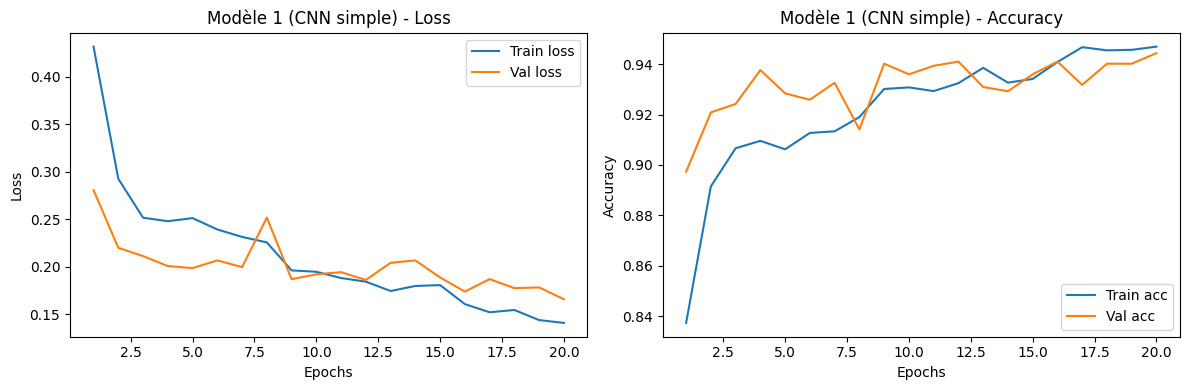

In [7]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix="Modèle 1"):
    hist = history.history

    epochs_range = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, hist["loss"], label="Train loss")
    plt.plot(epochs_range, hist["val_loss"], label="Val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, hist["accuracy"], label="Train acc")
    plt.plot(epochs_range, hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history1, title_prefix="Modèle 1 (CNN simple)")


##  Évaluation sur l'ensemble de test

On mesure les performances finales sur `test_ds` :

- loss
- accuracy
- précision
- rappel

In [8]:
test_results1 = model1.evaluate(test_ds, verbose=1)
print("\nRésultats sur le test (Modèle 1) :")
for name, value in zip(model1.metrics_names, test_results1):
    print(f"{name}: {value:.4f}")

96/96 [==============================] - 4s 37ms/step - loss: 0.1951 - accuracy: 0.9418 - precision: 0.8948 - recall: 0.9395

Résultats sur le test (Modèle 1) :
loss: 0.1951
accuracy: 0.9418
precision: 0.8948
recall: 0.9395


## Matrice de confusion et rapport de classification

On calcule :

- la matrice de confusion,
- le rapport de classification (precision, recall, F1-score par classe).

Cela permet d'analyser plus finement les erreurs du modèle (par exemple : confond-il souvent *with mask* et *without mask* ?).


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Récupérer toutes les vraies étiquettes
y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())

y_true = np.concatenate(y_true, axis=0)

# Prédictions
y_pred_proba = model1.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


96/96 [==============================] - 3s 25ms/step
Confusion Matrix:
 [[1904  115]
 [  63  978]]

Classification Report:
              precision    recall  f1-score   support

        face       0.97      0.94      0.96      2019
    maskface       0.89      0.94      0.92      1041

    accuracy                           0.94      3060
   macro avg       0.93      0.94      0.94      3060
weighted avg       0.94      0.94      0.94      3060



## Analyse du Modèle 1 – CNN simple

### 🔹 Performances sur le test
- **Accuracy : 94.18%**
- **Precision : 89.48%**
- **Recall : 93.95%**
- **Loss : 0.1951**

Ces valeurs confirment que le CNN simple généralise très bien.

---

## 🔹 Matrice de confusion
| Classe     | Bien classé | Mal classé |
|------------|-------------|------------|
| face       | 1904        | 115        |
| maskface   | 978         | 63         |

- Le modèle a plus de mal à reconnaître *maskface* → 63 erreurs,
- mais les deux classes sont bien séparées (F1-score ≈ 0.92–0.96).

---

## 🔹 Courbes Loss & Accuracy

### 📉 Perte (Loss)
- La **train loss** diminue progressivement jusqu’à ~0.13.
- La **val loss** reste stable entre 0.17 et 0.22.
- Aucune explosion → **pas d’overfitting**.
- Les deux courbes se rapprochent à partir de l’époque 10 → modèle bien régularisé.

### 📈 Précision (Accuracy)
- La **train accuracy** monte lentement mais régulièrement pour atteindre ~95%.
- La **val accuracy** oscille entre 92% et 95%, mais reste **toujours élevée**.
- Le fait que la validation soit souvent légèrement supérieure au train est un bon signe :  
  → **le modèle n'apprend pas par cœur**, il généralise réellement.

---

## 🔹 Interprétation globale

- Le CNN simple fournit **d’excellents résultats** pour un modèle construit “from scratch”.
- Le modèle :
  - apprend vite,
  - ne surapprend pas,
  - garde une validation très stable,
  - atteint un **F1-score global autour de 94%**, ce qui est très bon pour une architecture simple.

➡️ **Ce modèle est une baseline solide et propre**.  
➡️ Il surpasse même VGG16 en version gelée.  

---

## 🔹 Conclusion
Le **CNN simple** est un très bon compromis performance / vitesse.  
Il constitue une très bonne référence pour comparer les modèles avancés (MobileNetV2, EfficientNetB0).
